In [14]:
from fit_completeness_to_catalog import *
name = "barclay"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Selected 415 stars


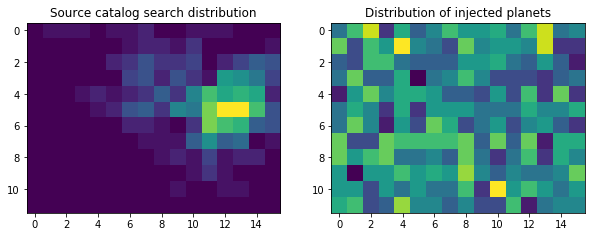

In [15]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
synth = make_synth_solar_systems(num_stars=num_stars)
hist_synth, hist_catalog = make_hists(synth, catalog)

In [16]:
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)
_ = sampler.run_mcmc(p0, 1000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 20000, store=True, progress="notebook")

Found least-squares solution: [ 2.12025735e+00 -1.49316678e-02  6.85352061e-05 -5.74549947e-02
  1.05601023e-02  5.58180719e-02 -3.66617857e-02 -5.42937327e-03]
Set initial condition


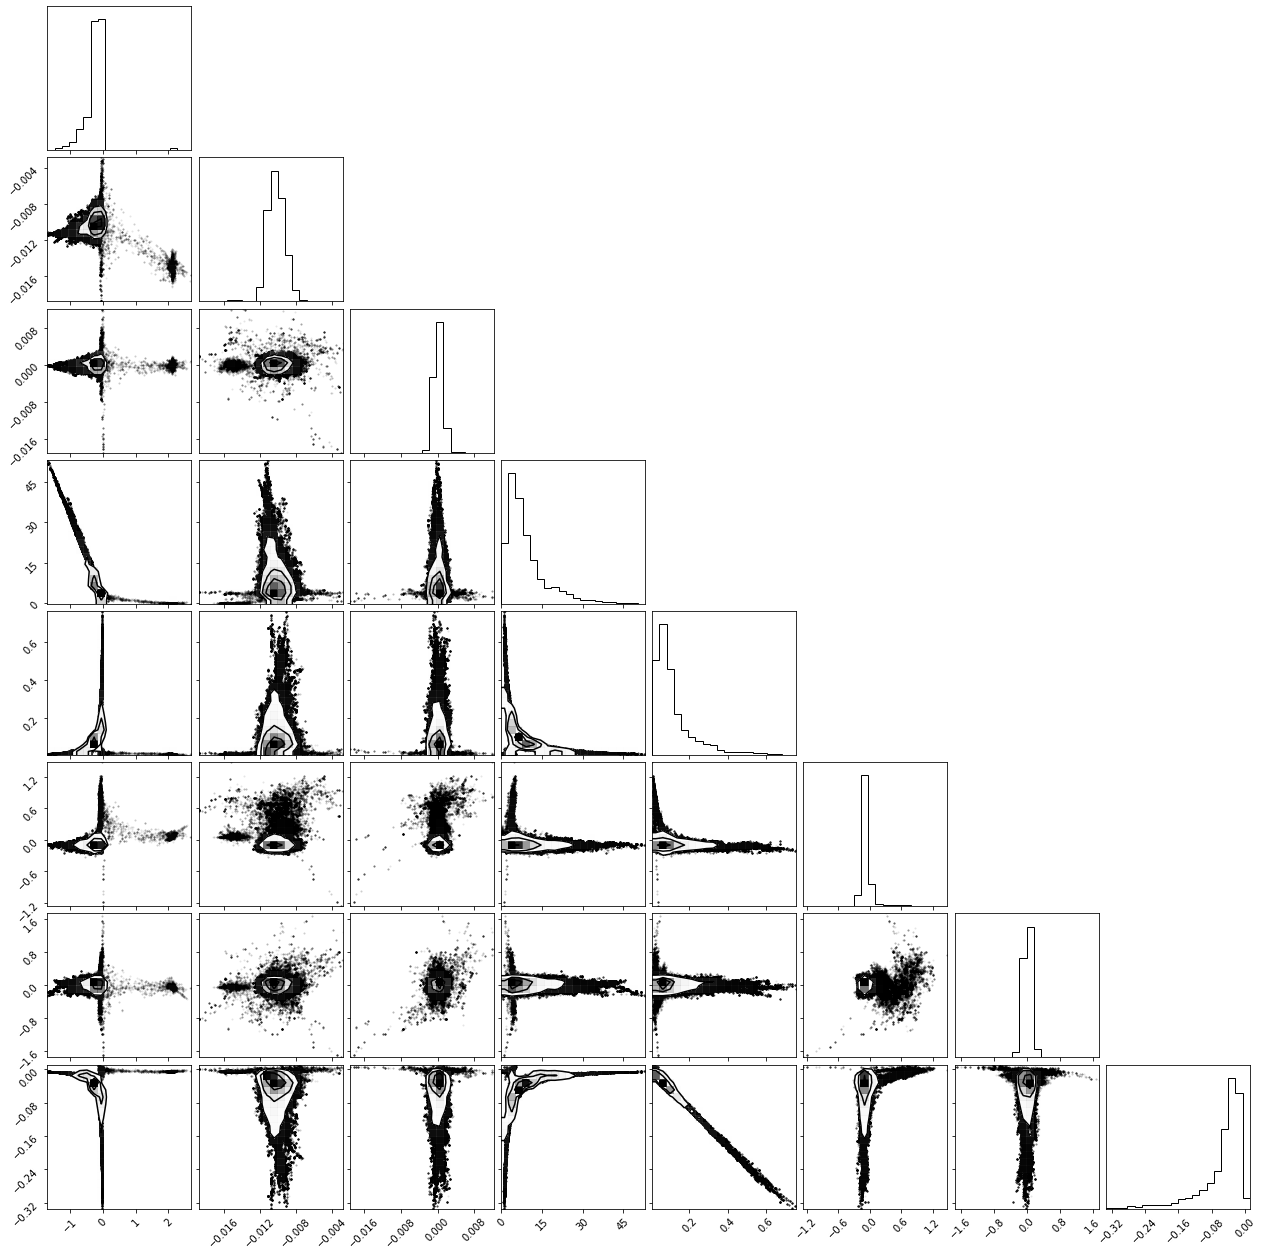

In [17]:
_ = corner.corner(sampler.flatchain)

In [20]:
ll(np.mean(sampler.flatchain,axis=0))

-556.3282921776854

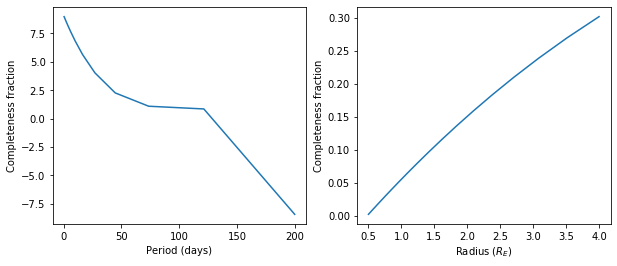

In [18]:
params = np.mean(sampler.flatchain, axis=0)
plot_marginalized_comps(params)

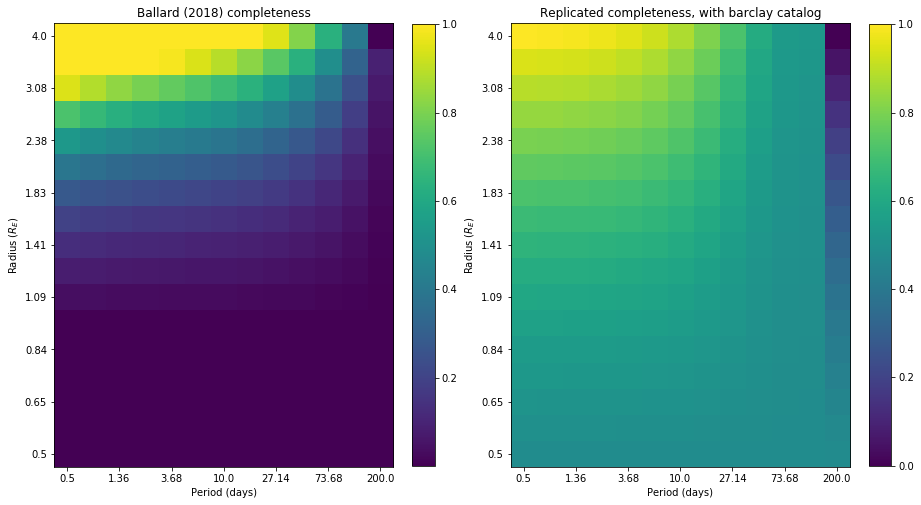

In [19]:
repcomp = np.outer(comp_poly(bins_p, *params[:4]), comp_poly(bins_r, *params[4:])).T
repcomp -= np.min(repcomp)
repcomp /= np.max(repcomp)
plot_overall_comps(repcomp, name)